# Exercise: Rootfinding

In [1]:
import os
from casadi import DM, MX, Function
import matplotlib.pyplot as plt
import numpy as np
import casadi as cas
from platform import python_version

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.5
Python: 3.10.13


In [2]:
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

In [3]:
def g(w):
    x = w[0]
    y = w[1]
    g1 = cas.tanh((x + 2) * y**2 / 25 - 0.5)
    g2 = cas.sin(x) - 0.5 * y + 1
    return cas.vertcat(g1, g2)

In [4]:
x0 = cas.vertcat(-0.8, 2)
g_test = g(x0)
g_test

DM([-0.298617, -0.717356])

In [5]:
assert g_test.shape == (2, 1)
assert np.array_equal(np.round(g_test, 4), [[-0.2986], [-0.7174]])

## 1. Rootfinding using finite differences

In [6]:
def estimate_Jacobian(f, x0, eps=1e-8):
    """Estimate the Jacobian matrix of function f(x) at x = x0
    using finite differences.
    """
    nx = x0.shape[0]
    assert x0.shape[1] == 1
    eps = DM(eps)
    if eps.shape[0] == 1:
        eps = cas.repmat(eps, nx)
    f0 = f(x0)
    nf = f0.shape[0]
    assert f0.shape[1] == 1
    dFdx_cols = []
    for i in range(nf):
        dx = DM.zeros(nx, 1)
        dx[i] = eps[i]
        Fx_p1 = f(x0 + dx)
        dFdx_cols.append((Fx_p1 - f0) / eps[i])
    return cas.hcat(dFdx_cols)


In [7]:
x0 = cas.vertcat(-0.8, 2)
J_test = estimate_Jacobian(g, x0, eps=1e-6)
J_test

DM(
[[0.145733, 0.174879], 
 [0.696707, -0.5]])

In [8]:
assert J_test.shape == (2, 2)
assert np.array_equal(np.round(J_test, 4), [[0.1457, 0.1749], [0.6967, -0.5000]])

### Visualization of partial variation of g(x)

In [9]:
def plot_func_variation(g, x0, x_min, x_max, x_pts=None, J=None, n=51):
    g0 = np.array(g(x0)).reshape(-1)
    ng = g0.shape[0]
    if x_pts is not None:
        g_pts = [np.array(g(x_pt)) for x_pt in x_pts]
        x_pts = [np.array(x_pt) for x_pt in x_pts]
    x0 = np.array(x0).reshape(-1)
    x_min = np.array(x_min).reshape(-1)
    x_max = np.array(x_max).reshape(-1)
    x_ranges = np.linspace(x_min, x_max, n)
    nx = x_ranges.shape[1]
    nk = x_ranges.shape[0]
    if J is not None:
        J = np.array(J)
        G_lin = np.zeros((2, nx, ng))
        for i in range(nx):
            X = np.repeat(x0.reshape(1, -1), 2, 0)
            X[:, i] = x_ranges[[0, -1], i]
            G_lin[0, i, :] = g0 + J @ (X[0, :] - x0)
            G_lin[1, i, :] = g0 + J @ (X[1, :] - x0)
    G = np.zeros((nk, nx, ng))
    for i in range(nx):
        X = np.repeat(x0.reshape(1, -1), nk, 0)
        X[:, i] = x_ranges[:, i]
        for k in range(X.shape[0]):
            G[k, i, :] = np.array(g(X[k, :].T)).reshape(-1)
    for j in range(ng):
        for i in range(nx):
            plt.subplot(ng, nx, j*2+i+1)
            plt.plot(x_ranges[:, i], G[:, i, j], label=f'$g_{j+1}(x)$')
            g_min, g_max = G[:, i, j].min(), G[:, i, j].max()
            if x_pts is not None:
                for k, (x_pt, g_pt) in enumerate(zip(x_pts, g_pts)):
                    plt.plot(x_pt[i], g_pt[j], '.', color='k',
                         label=f'$g_{j+1}(x^{k})$')
                    plt.annotate(f'{k}', xy=(x_pt[i], g_pt[j]), xytext=(0, 6), 
                                 textcoords='offset points', ha='center')
            if J is not None:
                # Only show linear approx. for x0 point
                plt.plot(x_ranges[[0, -1], i], G_lin[:, i, j], '--')
                g_min, g_max = min(g_min, G_lin[:, i, j].min()), max(g_max, G_lin[:, i, j].max())
            plt.xlim(x_ranges[[0, -1], i])
            plt.ylim([g_min, g_max])
            plt.xlabel(f'$x_{i+1}$')
            plt.ylabel(f'$g_{j+1}(x)$')
            plt.grid()
    plt.tight_layout()


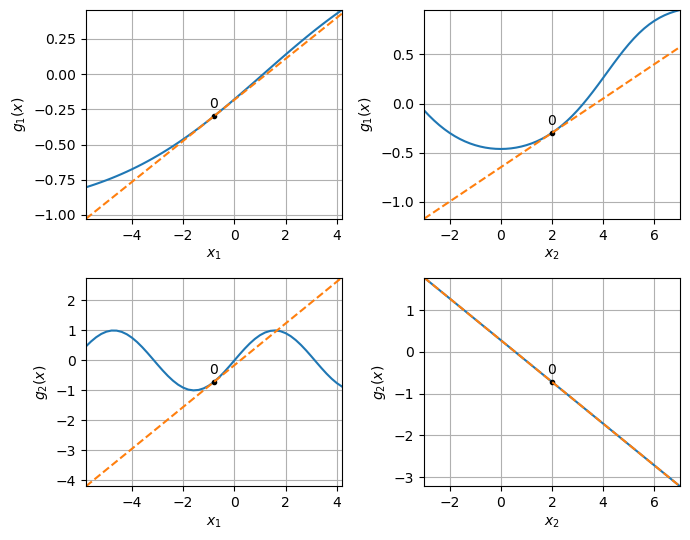

In [10]:
x_pts = [x0]
J = estimate_Jacobian(g, x0, eps=1e-6)
x_min = np.array(x0).reshape(-1) - 5
x_max = np.array(x0).reshape(-1) + 5
plt.figure(figsize=(7, 5.5))
plot_func_variation(g, x0, x_min, x_max, J=J, x_pts=x_pts)

### Newton steps

In [11]:
x0 = cas.vertcat(-0.8, 2)
J = estimate_Jacobian(g, x0, eps=1e-6)
dx = cas.solve(J, -g(x0))
x1 = x0 + dx
x1

DM([0.611149, 2.5316])

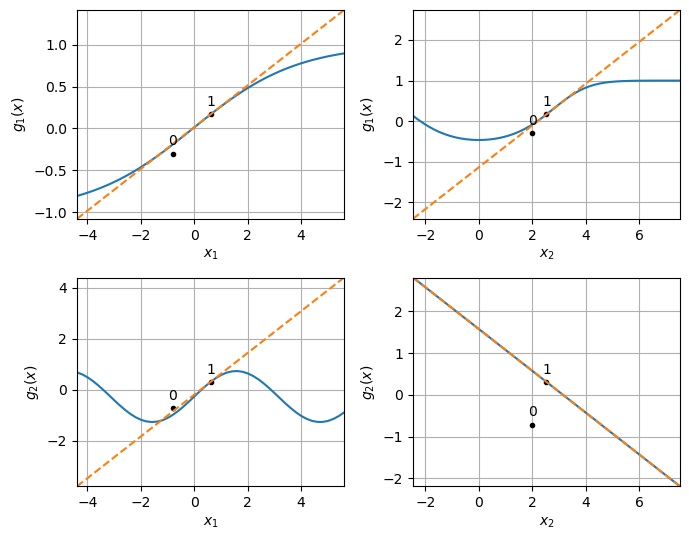

In [12]:
x_pts = [x0, x1]
J = estimate_Jacobian(g, x1, eps=1e-6)
x_min = np.array(x1).reshape(-1) - 5
x_max = np.array(x1).reshape(-1) + 5
plt.figure(figsize=(7, 5.5))
plot_func_variation(g, x1, x_min, x_max, J=J, x_pts=x_pts)

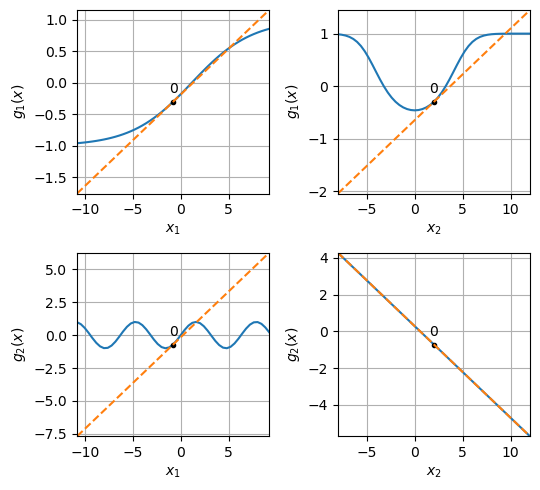

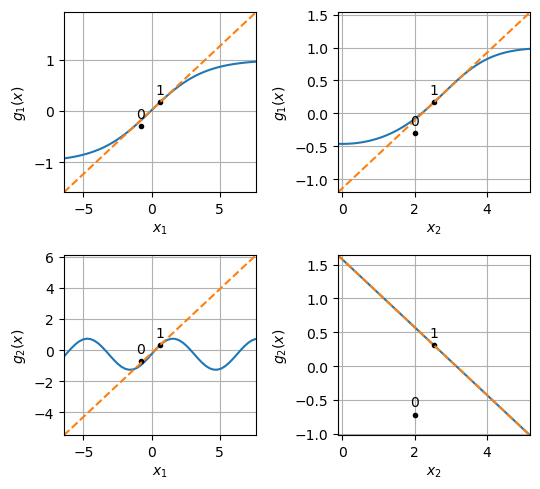

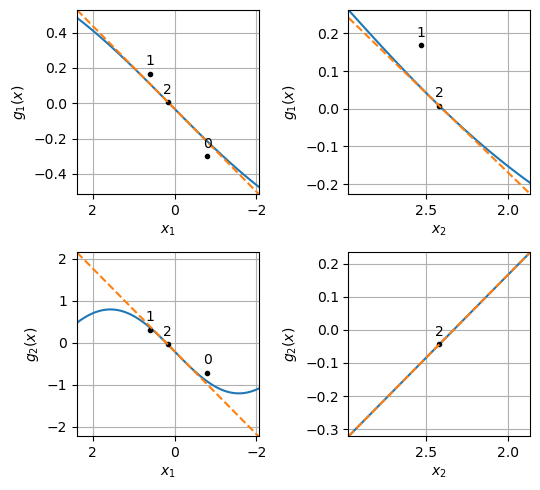

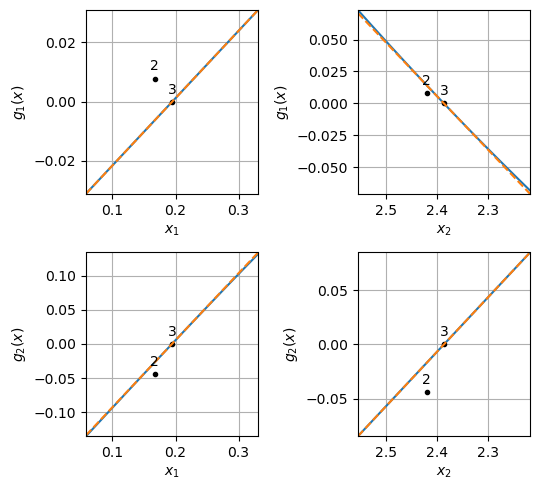

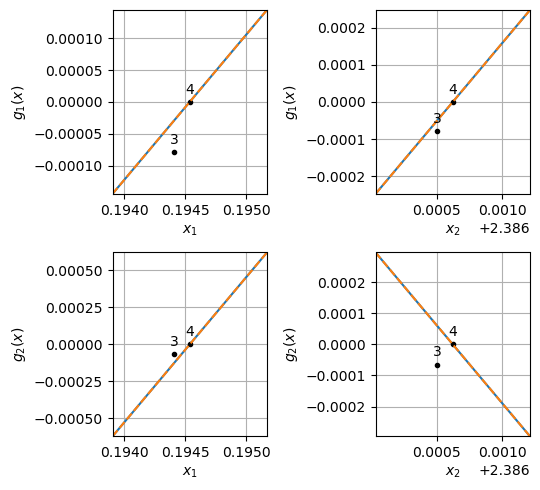

In [13]:
x0 = cas.vertcat(-0.8, 2)
x_pts_fd = [x0]
x = x0
dx = DM([2, 2])
for i in range(5):
    J = estimate_Jacobian(g, x, eps=1e-6)

    plt.figure(figsize=(5.5, 5))
    x_min = np.array(x - dx * 5).reshape(-1) 
    x_max = np.array(x + dx * 5).reshape(-1)
    plot_func_variation(g, x, x_min, x_max, J=J, x_pts=x_pts_fd)
    filename = f'newton_step_{i+1}_fd.pdf'
    plt.savefig(os.path.join(plot_dir, filename))

    dx = cas.solve(J, -g(x))
    x += dx
    x_pts_fd.append(x)


In [14]:
x_pts_fd

[DM([-0.8, 2]),
 DM([0.611149, 2.5316]),
 DM([0.167149, 2.42036]),
 DM([0.194409, 2.3865]),
 DM([0.194536, 2.38662]),
 DM([0.194536, 2.38662])]

In [15]:
assert np.array_equal(np.round(x_pts_fd[5], 4), [[0.1945], [2.3866]])

## 2. Rootfinding using CasADi Jacobian

In [16]:
# Define symbol
x = MX.sym('x')

# CasADi functions
f = Function('f',[x], [cas.sin(x) - 0.5])
f(0.8) # evaluate for x=0.8

DM(0.217356)

In [17]:
X = MX.sym('X', 2)  # vector
assert X.shape == (2, 1)
g(X)

MX(@1=X[0], @2=X[1], vertcat(tanh(((((2+@1)*sq(@2))/25)-0.5)), (1+(sin(@1)-(0.5*@2)))))

In [18]:
assert isinstance(g(X), MX)
assert g(X).shape == (2, 1)

In [19]:
J = cas.jacobian(g(X), X)
J

MX(@1=X[0], @2=(2+@1), @3=X[1], @4=sq(@3), @5=(1-sq(tanh((((@2*@4)/25)-0.5)))), @6=0.04, ((zeros(2x2)[:4:2] = vertcat((@5*(@6*@4)), cos(@1)))[1:5:2] = vertcat((@5*(@6*(@2*(2.*@3)))), -0.5))')

In [20]:
# Create function to to map from X to J
Jf = Function('Jf', [X], [J])
Jf

Function(Jf:(i0[2])->(o0[2x2]) MXFunction)

In [21]:
x0 = cas.vertcat(-0.8, 2)
J_test = np.array(Jf(x0))
J_test

array([[ 0.14573251,  0.17487901],
       [ 0.69670671, -0.5       ]])

In [22]:
assert J_test.shape == (2, 2)
assert np.max(np.abs(J_test - DM([[0.1457, 0.1749], [0.6967, -0.5000]]))) < 1e-4

### Newton steps

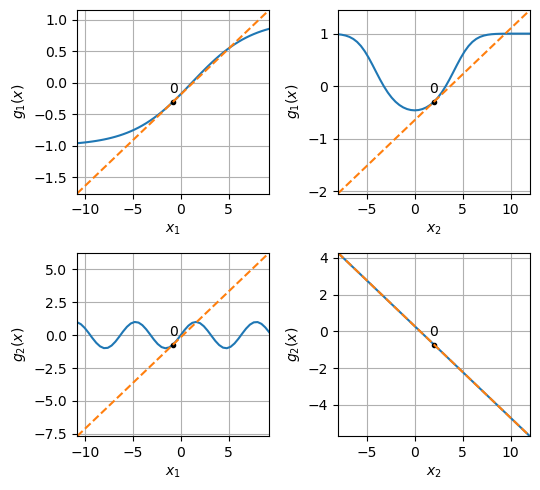

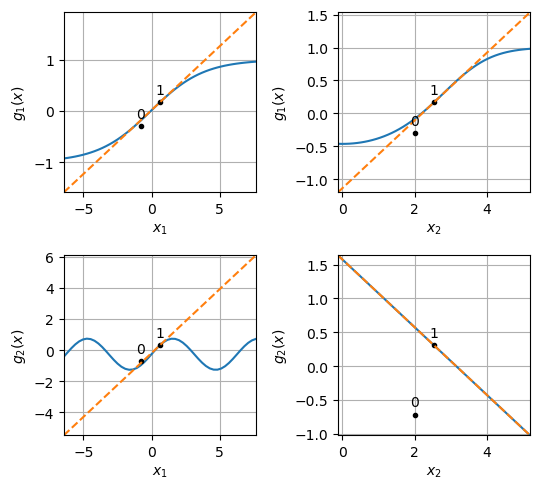

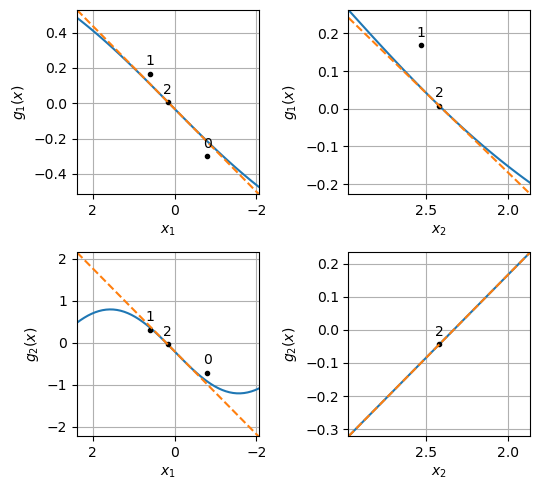

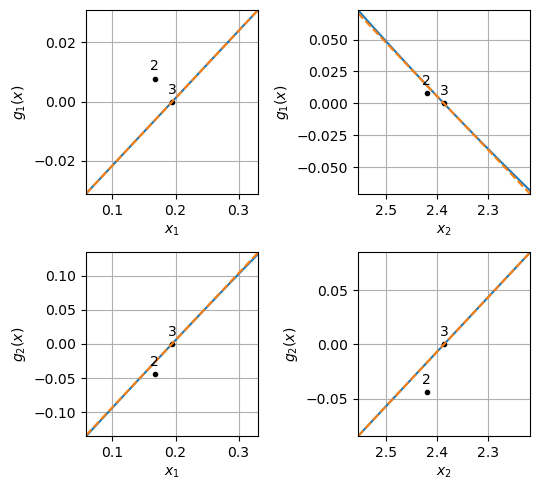

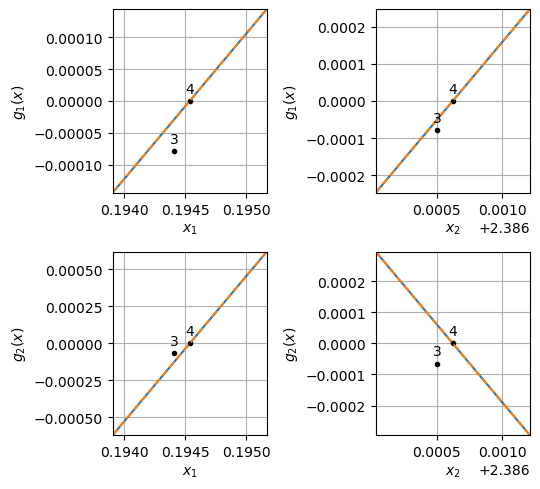

<Figure size 550x500 with 0 Axes>

In [23]:
x0 = cas.vertcat(-0.8, 2)
x_pts_ad = [x0]
x = x0
dx = DM([2, 2])
for i in range(25):
    J = Jf(x)

    plt.figure(figsize=(5.5, 5))
    x_min = np.array(x - dx * 5).reshape(-1) 
    x_max = np.array(x + dx * 5).reshape(-1)

    if i < 5:
        plot_func_variation(g, x, x_min, x_max, J=J, x_pts=x_pts_ad)
        filename = f'newton_step_{i+1}_ad.pdf'
        plt.savefig(os.path.join(plot_dir, filename))

    dx = cas.solve(J, -g(x))
    if np.all(np.abs(dx) < 1e-15):
        break
    
    x += dx
    x_pts_ad.append(x)


In [24]:
x_pts_ad

[DM([-0.8, 2]),
 DM([0.61115, 2.5316]),
 DM([0.167149, 2.42036]),
 DM([0.194409, 2.3865]),
 DM([0.194536, 2.38662]),
 DM([0.194536, 2.38662])]

In [25]:
assert np.max(np.abs(x_pts_ad[5] - [0.1945, 2.3866]) < 1e-4)

In [26]:
x_sol = np.array([0.1945357806477383, 2.3866221855735548]).reshape(-1)
pts_fd = np.stack([np.array(x).reshape(-1) - x_sol for x in x_pts_fd])
pts_ad = np.stack([np.array(x).reshape(-1) - x_sol for x in x_pts_ad])
np.hstack([pts_fd, pts_ad]).round(4)

array([[-9.945e-01, -3.866e-01, -9.945e-01, -3.866e-01],
       [ 4.166e-01,  1.450e-01,  4.166e-01,  1.450e-01],
       [-2.740e-02,  3.370e-02, -2.740e-02,  3.370e-02],
       [-1.000e-04, -1.000e-04, -1.000e-04, -1.000e-04],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00]])

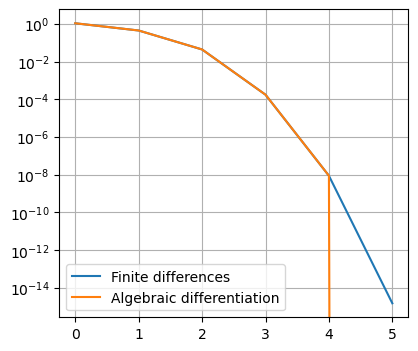

In [27]:
norms_ad = np.linalg.norm(pts_ad, axis=1)
norms_fd = np.linalg.norm(pts_fd, axis=1)

plt.figure(figsize=(4.5, 4))
k = np.arange(norms_ad.shape[0])
plt.plot(k, norms_fd, label='Finite differences')
plt.plot(k, norms_ad, label='Algebraic differentiation')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

## 3. CasADi’s rootfinder

In [28]:
x = MX.sym('x', 2)
rf = cas.rootfinder('rf', 'newton', {'x': x, 'g': g(x)})
rf

Function(rf:(x0[2],p[])->(x[2]) Newton)

In [29]:
x_sol_rf = rf([-0.8, 2], [])
x_sol_rf

DM([0.194536, 2.38662])

In [30]:
assert np.max(np.abs(x_sol_rf - [0.1945, 2.3866]) < 1e-4)
assert np.max(np.abs(x_sol_rf - x_sol) < 1e-16)

In [31]:
rf.stats()

{'iter_count': 6,
 'n_call_g': 0,
 'n_call_jac_f_z': 0,
 'return_status': 'success',
 'success': True,
 't_proc_g': 0.0,
 't_proc_jac_f_z': 0.0,
 't_wall_g': 0.0,
 't_wall_jac_f_z': 0.0,
 'unified_return_status': 'SOLVER_RET_UNKNOWN'}

In [32]:
options = {'print_iteration': True}
rf = cas.rootfinder('rf', 'newton', {'x': x, 'g': g(x)}, options)
x_sol_rf = rf([-0.8, 2], [])

 iter       res      step     alpha
    1  7.17e-01  1.41e+00  1.00e+00
    2  3.08e-01  4.44e-01  1.00e+00
    3  4.38e-02  3.39e-02  1.00e+00
    4  7.84e-05  1.27e-04  1.00e+00
    5  4.09e-09  8.31e-09  1.00e+00
